In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from IPython.display import display

Сначала напишу калькулятор для левосторонней проверки, потом добавлю отсальные

Исходные данные:
- среднее распределения p1 (control)
- MDE
- $\alpha$ и $\beta$
- $n$

Дополнительно написать код для формирования таблицы взаимосвязи $n$ от $\alpha$ и $\beta$

In [3]:
def get_n(p_c, mde, alpha, beta, orientation, plot=True):
    """
    Функция нахождения требуемого количества наблюдений исходя
    из извесных mde, alpha, beta, p_c (среднее исходного распределения)
    """
    p_t = p_c + mde # ожидаемое среднее распределения после внедрения фичи (treatment)
    
    # дисперсия распределений
    sigma_c = p_c * (1 - p_c)
    sigma_t = p_t * (1 - p_t)    
    
    # оценка q - параметра для оптимальной разбивки по группам (для расчета количества наблюдений в каждой группе)
    # формула выведена через минимизацию дисперсии случайной величины p1 - p2
    q = np.sqrt(sigma_c) / (np.sqrt(sigma_c) + np.sqrt(sigma_t))
    
    one_sided_orientation = orientation in ['left', 'right']
    
    if one_sided_orientation:
        z_alpha = stats.norm.ppf(1 - alpha) # кванитль для Z_1-alpha
        z_beta = stats.norm.ppf(1 - beta) # кванитль для Z_1-beta   
    else:
        z_alpha = stats.norm.ppf(1 - alpha/2) # кванитль для Z_1-alpha
        z_beta = stats.norm.ppf(1 - beta/2) # кванитль для Z_1-beta          
    
    # оценка количества наблюдений для проведения эксперимента
    n = round(((z_alpha + z_beta) / mde) **2 * (sigma_c/q + sigma_t/(1-q)))
    
    # требуемое количество наблюдений в control группе
    n_c = round(q * n)
    
    # требуемое количество наблюдений в treatment группе
    n_t = round((1- q) * n)
    
    
    # строим графики
    if plot:
        x_c = np.linspace(stats.norm.ppf(0.01), 
                        stats.norm.ppf(0.99),
                        100)
        y_c = stats.norm.pdf(x_c)
        
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(10, 5)
        ax.plot(x_c, y_c, label='norm_distirbution')
        
        if one_sided_orientation:
            plt.axvline(z_alpha, color='red', linestyle='--', label='z_alpha')
            plt.axvline(z_beta, color='green', linestyle='--', label='z_beta')
            
            for z in [z_alpha, z_beta]:
                xq = np.linspace(z, stats.norm.ppf(0.99), 100)
                yq = stats.norm.pdf(xq)

                if z == z_alpha:
                    color = 'red'
                else:
                    color = 'green'
                        
                plt.fill_between(xq, 0, yq, color=color, alpha=0.3)
        else:
            plt.axvline(z_alpha, color='red', linestyle='--', label='z_alpha')
            plt.axvline(-z_alpha, color='red', linestyle='--', label='-z_alpha')
            plt.axvline(z_beta, color='green', linestyle='--', label='z_beta')
            plt.axvline(-z_beta, color='green', linestyle='--', label='-z_beta')
            
            for z in [z_alpha, z_beta]:
                
                if z == z_alpha:
                    color = 'red'
                else:
                    color = 'green'
                
                for sign in [-1, 1]:
                    if sign == -1:
                        xq = np.linspace(stats.norm.ppf(0.01), z * sign, 100)
                        yq = stats.norm.pdf(xq)
                    else:
                        xq = np.linspace(z * sign, stats.norm.ppf(0.99), 100)
                        yq = stats.norm.pdf(xq)                        
                    
                    plt.fill_between(xq, 0, yq, color=color, alpha=0.3)
            
        plt.title('get_n | Probability density function')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.legend()
        plt.show()        
    
    return n_c, n_t

In [3]:
def generating_bern_data(p, mde, alpha, beta, plot=True):
    """
    Функция для генерации выборок при заданных параметрах распределении
    для последующей демонстрации влияния beta на размер выборки
    """
    
    # считаем размеры выборок исходя из парометров теста
    na, nb = get_n(p, mde, alpha, beta, plot=False)
    
    # генерируем выборки
    a = np.random.binomial(1, p, na)
    b = np.random.binomial(1, p+mde, nb)
    
    # считаем средние и дисперсии выборок
    pa = a.sum() / len(a)
    pb = b.sum() / len(b)
    sigm_pa = pa * (1 - pa) / na
    sigm_pb = pb * (1 - pb) / nb
    
    # создаем распределения средних
    norm_a = stats.norm(pa, np.sqrt(sigm_pa))
    norm_b = stats.norm(pb, np.sqrt(sigm_pb))
    
    # квантили для alpha и beta
    z_alpha_a = norm_a.ppf(1 - alpha)
    z_beta_b = norm_b.ppf(beta)
    
    if plot:
        x_a = np.linspace(norm_a.ppf(0.0001), norm_a.ppf(0.9999), 100)
        y_a = norm_a.pdf(x_a)

        x_b = np.linspace(norm_b.ppf(0.0001), norm_b.ppf(0.9999), 100)
        y_b = norm_b.pdf(x_b)


        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(10, 5)
        ax.plot(x_a, y_a, label='norm_distirbution_a')
        ax.plot(x_b, y_b, label='norm_distirbution_b')
        plt.axvline(z_alpha_a, color='red', linestyle='--', label='z_alpha_a')
        plt.axvline(z_beta_b, color='green', linestyle='--', label='z_beta_b')
        plt.title('Probability density function of normalized sample mean')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.legend()
        plt.show()
        
    return a, b

In [4]:
def bern_z_test(c, t, alpha, orientation, plot=True):
    """
        Функция для проверки нулевой гипотезы о разнице средних для биномиального распределения.
    """
    c_mean_hat = c.sum() / len(c)
    c_mean_hat_sigma = (c_mean_hat * (1-c_mean_hat)) / len(c)
    
    t_mean_hat = t.sum() / len(t)
    t_mean_hat_sigma = (t_mean_hat * (1-t_mean_hat)) / len(t)
    
    # путь через z-критерий
    # нормирование случайной величины разницы средних
    z = (t_mean_hat - c_mean_hat) / np.sqrt(t_mean_hat_sigma + c_mean_hat_sigma)
    
    
    if orientation == 'right':
        z_alpha = stats.norm.ppf(1-alpha) 
        p_value = 1 - stats.norm.cdf(z)
        
    elif orientation == 'left':
        z_alpha = stats.norm.ppf(alpha)
        p_value = stats.norm.cdf(z)
    
    elif orientation == 'twosided':
        left, right = stats.norm.interval(1 - alpha) # функция сама считает alpha/2
        if z <= 0:
            p_value = stats.norm.cdf(z)
        else:
            p_value = 1-stats.norm.cdf(z)
        
    else:
        print('Unknown orientation')
        return
    
    if plot:
        x = np.linspace(stats.norm.ppf(0.001), stats.norm.ppf(0.999), 100)
        pdf = stats.norm.pdf(x)

        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(10, 5)
        ax.plot(x, pdf, label='norm_distirbution')
        plt.axvline(z, color='blue', linestyle='-.', label = 'z')
        
        if orientation in ['left', 'right']:
            if orientation == 'left':
                label = f'{alpha} quantile'
            else:
                label = f'{1 - alpha} quantile'
            plt.axvline(z_alpha, color='red', linestyle='dashed', label=label)
            
        else:
            plt.axvline(left, color='red', linestyle='-.', label = f'{alpha / 2} quantile')
            plt.axvline(right, color='red', linestyle='-.', label = f'{1 - alpha / 2} quantile')
            
        if orientation == 'left' or (orientation == 'twosided' and z <= 0):
            if stats.norm.ppf(0.001) <= z:
                xq = np.linspace(stats.norm.ppf(0.001), z, 100)
            else:
                xq = np.linspace(z, z, 1)
        else:
            if stats.norm.ppf(0.999) >= z:
                xq = np.linspace(z, stats.norm.ppf(0.999), 100)
            else:
                xq = np.linspace(z, z, 1)              

        yq = stats.norm.pdf(xq) 
        plt.fill_between(xq, 0, yq, color='blue', alpha=0.3)
        
        y_max = plt.ylim()[1]
        text_margin = 0.05
        
        plt.text(z + text_margin, 0.8*y_max, f'p_vlaue: {round(p_value, 2)}', color="blue", fontsize=10)
        plt.title(f'bern_z_test | Probability density function (Z-test, alpha: {alpha})')
        plt.xlabel('$x$')
        plt.ylabel('$pdf(x)$')
        plt.legend(loc='upper left')
        plt.show()    
        
    accept = False # флаг, принимаем ли мы нулевую гипотезу в итоге
        
    if orientation == 'left':
        if z >= z_alpha:
            accept = True
        
    elif orientation == 'right':
        if z <= z_alpha:
            accept = True
            
    else:
        if left <= z <= right:
            accept = True
            
    if plot:
        if accept:
            print(f'Принимаем нулевую гипотезу о равенстве средних. p_value = {p_value}')
        else:
            print(f'Отвергаем нулевую гипотезу о равенстве средних. p_value = {p_value}')
        
    return accept

In [2]:
def observations_count(p, mde, orientation):
    """
    Функция для подсчета размера выборки для проведения A/B теста для распределения Бернулли
    в зависимости от текущего параметра среднего распределения и желаемого MDE
    """
    alphas = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
    betas = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]

    observations = [ ]
    for alpha in alphas:
        observations_cur = [ ]
        for beta in betas:
            o = sum(get_n(p, mde, alpha, beta, orientation, plot=False))
            observations_cur.append(o)
        observations.append(observations_cur)

    df_e = pd.DataFrame(observations)
    df_e.columns = alphas
    df_e.index= betas
    return df_e

In [5]:
observations_count(0.2, 0.05, 'right')

,0.001,0.010,0.020,0.050,0.100,0.200
0.001,10602,8144,7344,6223,5305,4291
0.010,8144,6009,5325,4377,3613,2786
0.020,7344,5325,4683,3797,3088,2327
0.050,6223,4377,3797,3004,2377,1716
0.100,5305,3613,3088,2377,1823,1251
0.200,4291,2786,2327,1716,1251,786


__Пайплайн__:
- приходит менеджер и говорит что нужне АБ
- уточняем про направление A/B (двухсторонее, левосторонее или правосторонее)
- уточняем параметр MDE 
- говорим про то, что нужно подумать над тем, какие ошибки alpha и beta мы можем себе позволить
- оцениваем текущую статистику
- скидываем таблицу с размерами выборки для эксперемента
- получаем параметры alpha и beta
- запускаем A/B
- считаем результаты

,0.001,0.010,0.020,0.050,0.100,0.200
0.001,1586557,1218607,1099037,931256,793836,642108
0.010,1218607,899131,796858,655024,540658,416846
0.020,1099037,796858,700758,568184,462044,348194
0.050,931256,655024,568184,449498,355699,256792
0.100,793836,540658,462044,355699,272864,187234
0.200,642108,416846,348194,256792,187234,117681


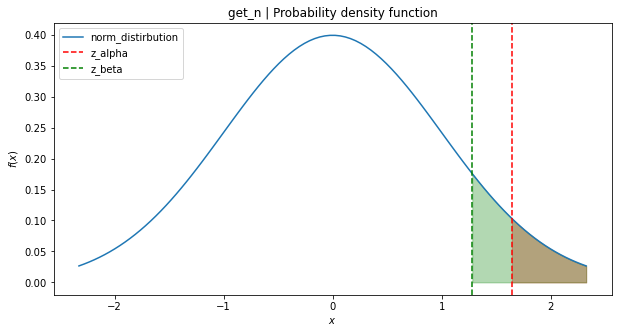

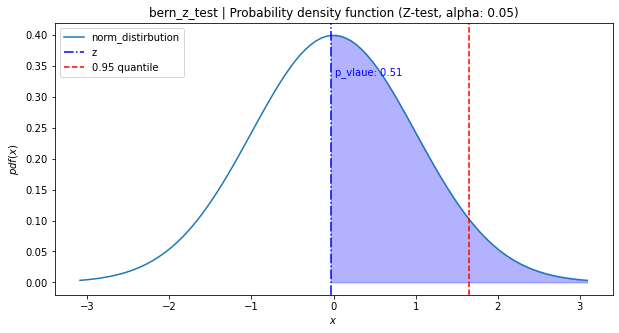

Принимаем нулевую гипотезу о равенстве средних. p_value = 0.512564470803984


True

In [6]:
# настройка графиков
plot = True

# выбор направления
orientation = 'right'

# уточняем параметр MDE
mde = 0.001

# оцениваем текущую статистику
p = 0.01

# скидываем таблицу с размерами выборки для экперимента
display(observations_count(p, mde, orientation))

# получаем alpha и beta
alpha, beta = 0.05, 0.1

# считаем размеры выборок
n_c, n_t = get_n(p, mde, alpha, beta, orientation, plot=plot)

# запускаем A/B
p_t = 0.01 # пример среденего для treatment выборки, полученной в результате A/B
c = np.random.binomial(1, p, n_c)
t = np.random.binomial(1, p_t, n_t)

# счтитем результаты
bern_z_test(c, t, alpha, orientation, plot)

#  Тесты

In [7]:
# # тестирование
# p = 0.01
# mde = 0.001
# alpha = 0.001
# beta = 0.001

# ans = [ ]
# for _ in tqdm(range(100)):
#     a, b = generating_bern_data(p, mde, alpha, beta, plot=False)
#     reject = bern_z_test(a, b, alpha, plot=False)
#     ans.append(reject)
    
# print(f'''Несмотря на то, что данные были сгенерированы из разных выборок,
# мы совершаем ошибку 2го рода принимая гипотезу о равенстве средних в {round(sum(ans) / len(ans) * 100, 2)}% случаях.
# Эта доля примерно равняется нашему параметру beta, равному {beta}''')

In [19]:
# тест параметра alpha

plot = False
mde = 0.001
p = p_t = 0.086
alpha, beta = 0.01, 0.1

for orientation in ['left', 'right', 'twosided']:
    test_result = [ ]
    
    n_c, n_t = get_n(p, mde, alpha, beta, orientation, plot=plot)
    
    for _ in tqdm(range(2000)):
        c = np.random.binomial(1, p, n_c)
        t = np.random.binomial(1, p_t, n_t)
        ans = bern_z_test(c, t, alpha, orientation, plot)
        test_result.append(ans)

    print(f'{orientation} | {alpha} | {sum(test_result) / len(test_result)}') 

  0%|          | 0/2000 [00:00<?, ?it/s]

left | 0.01 | 0.9905


  0%|          | 0/2000 [00:00<?, ?it/s]

right | 0.01 | 0.9885


  0%|          | 0/2000 [00:00<?, ?it/s]

twosided | 0.01 | 0.9935


In [17]:
# тест параметра beta

# нам неинтересно смотреть результат beta для 2х сторонней проверки, т.к. тут отсутсвует предположение об mde
# другими словами, это только проверка гипотезы на равенство средних

plot = False

MDE = 0.001
p = 0.01

alpha, beta = 0.1, 0.2

for orientation in ['left', 'right']:
    test_result = [ ]
    
    if orientation == 'left':
        mde = -MDE
    else:
        mde = MDE

    p_t = p + mde
    
    n_c, n_t = get_n(p, mde, alpha, beta, orientation, plot=plot)
    
    for _ in tqdm(range(2000)):
        c = np.random.binomial(1, p, n_c)
        t = np.random.binomial(1, p_t, n_t)
        ans = bern_z_test(c, t, alpha, orientation, plot)
        test_result.append(ans)

    print(f'{orientation} | {alpha} | {beta} | {sum(test_result) / len(test_result)}') 

  0%|          | 0/2000 [00:00<?, ?it/s]

left | 0.1 | 0.2 | 0.198


  0%|          | 0/2000 [00:00<?, ?it/s]

right | 0.1 | 0.2 | 0.201
